In [135]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from scrapData import GetHouseList
import re
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing,linear_model
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.feature_selection import f_regression,SelectKBest
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import PolynomialFeatures,OneHotEncoder,LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model,ensemble
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.decomposition import PCA,TruncatedSVD
from scipy.stats import pearsonr
import pickle
np.random.seed(123)


# Loading Data

In [68]:
df=pd.read_csv('Data/olx_data_all.csv')
df.head()

,Amenities,Bedrooms,Bathrooms,Area (m²),Furnished,Level,Ad Type,Type,Payment Option,price,title,location,Compound
0,"Balcony,Security,Covered Parking,Electricity M...",3,2,135,No,5,For Sale,Apartment,Cash,"1,600,000 EGP",مدينتي ١٣٥م بال B1 بحري قريبه جدا من الخدم...,Madinaty,Madinaty
1,"Balcony,Pets Allowed,Private Garden,Security,E...",3,2,140,No,2,For Sale,Apartment,Cash,"355,000 EGPnegotiable",شقة بسعر التكلفة في الحي المتميز مدينة بدر...,Badr City,El Ashgar District
2,NaN,3,3,180,No,Ground,For Sale,Apartment,Cash,"3,100,000 EGP",فرررصة برحاب ٢ للبيع شقة ١٨٠م ارضي بحديقة ...,Rehab City,NaN
3,"Balcony,Pets Allowed,Security,Electricity Mete...",2,1,107,No,6,For Sale,Apartment,Cash,"1,150,000 EGP",شقة بمدينتي بال B1 نموذج 100 اقل من سعر ال...,Madinaty,Madinaty
4,"Balcony,Electricity Meter",2,1,80,No,6,For Sale,Apartment,Cash,"185,000 EGP",شقة تشطيب فاخر للبيع,Marg,NaN


# Data Cleaning

In [69]:
df.shape

(26500, 13)

In [70]:
# remove measure unit of price(EGP)
df['price']=df['price'].apply(lambda x: x.replace('EGP','').replace(',','').replace('negotiable','').strip())
df.head()

,Amenities,Bedrooms,Bathrooms,Area (m²),Furnished,Level,Ad Type,Type,Payment Option,price,title,location,Compound
0,"Balcony,Security,Covered Parking,Electricity M...",3,2,135,No,5,For Sale,Apartment,Cash,1600000,مدينتي ١٣٥م بال B1 بحري قريبه جدا من الخدم...,Madinaty,Madinaty
1,"Balcony,Pets Allowed,Private Garden,Security,E...",3,2,140,No,2,For Sale,Apartment,Cash,355000,شقة بسعر التكلفة في الحي المتميز مدينة بدر...,Badr City,El Ashgar District
2,NaN,3,3,180,No,Ground,For Sale,Apartment,Cash,3100000,فرررصة برحاب ٢ للبيع شقة ١٨٠م ارضي بحديقة ...,Rehab City,NaN
3,"Balcony,Pets Allowed,Security,Electricity Mete...",2,1,107,No,6,For Sale,Apartment,Cash,1150000,شقة بمدينتي بال B1 نموذج 100 اقل من سعر ال...,Madinaty,Madinaty
4,"Balcony,Electricity Meter",2,1,80,No,6,For Sale,Apartment,Cash,185000,شقة تشطيب فاخر للبيع,Marg,NaN


In [71]:
df['Payment Option'].unique()

array(['Cash'], dtype=object)

In [72]:
# remove property type where all properties are Apartments
df.drop(['Type','Ad Type','Payment Option'],axis=1,inplace=True)
df.columns

Index(['Amenities', 'Bedrooms', 'Bathrooms', 'Area (m²)', 'Furnished', 'Level',
       'price', 'title', 'location', 'Compound'],
      dtype='object')

In [73]:
#rename Area (m²) to Area 
df.rename(columns={'Area (m²)':'Area'},inplace=True)

In [74]:
#check null values
df.isna().sum()

Amenities     7636
Bedrooms         0
Bathrooms        0
Area             0
Furnished     5023
Level            5
price            0
title            0
location         0
Compound     18912
dtype: int64

In [75]:
df.Compound.value_counts()

Madinaty                2747
Rehab City               764
Not in Compound          338
Eastown                  316
The Square               276
                        ... 
Opera City                 1
Zizinia El Mostakbal       1
Rayhanah Avenue            1
Mountain View 1            1
Aeon                       1
Name: Compound, Length: 214, dtype: int64

In [76]:
# fill aminities NaN with No
df.Amenities.fillna('No',inplace=True)
df.Furnished.fillna('No',inplace=True)
df.Compound.fillna('Not in Compound',inplace=True)
df.head()

,Amenities,Bedrooms,Bathrooms,Area,Furnished,Level,price,title,location,Compound
0,"Balcony,Security,Covered Parking,Electricity M...",3,2,135,No,5,1600000,مدينتي ١٣٥م بال B1 بحري قريبه جدا من الخدم...,Madinaty,Madinaty
1,"Balcony,Pets Allowed,Private Garden,Security,E...",3,2,140,No,2,355000,شقة بسعر التكلفة في الحي المتميز مدينة بدر...,Badr City,El Ashgar District
2,No,3,3,180,No,Ground,3100000,فرررصة برحاب ٢ للبيع شقة ١٨٠م ارضي بحديقة ...,Rehab City,Not in Compound
3,"Balcony,Pets Allowed,Security,Electricity Mete...",2,1,107,No,6,1150000,شقة بمدينتي بال B1 نموذج 100 اقل من سعر ال...,Madinaty,Madinaty
4,"Balcony,Electricity Meter",2,1,80,No,6,185000,شقة تشطيب فاخر للبيع,Marg,Not in Compound


In [77]:
df.Furnished.value_counts()

No     24693
Yes     1807
Name: Furnished, dtype: int64

In [78]:
#check level values
print(df.Level.unique(),pd.isnull( df.Level).sum(),df.Level.mode()[0])

['5' '2' 'Ground' '6' '4' '3' '1' '8' '10+' '9' '7' 'Highest' '10' nan] 5 2


In [79]:
df.Level.replace('Ground','0',inplace=True)
df.Level.replace('10+','10',inplace=True)
df.Level.replace('Highest','11',inplace=True)
df.Level.fillna(str(df.Level.mode()[0]),inplace=True)
df.Level.unique()

array(['5', '2', '0', '6', '4', '3', '1', '8', '10', '9', '7', '11'],
      dtype=object)

In [80]:
df.isna().sum()

Amenities    0
Bedrooms     0
Bathrooms    0
Area         0
Furnished    0
Level        0
price        0
title        0
location     0
Compound     0
dtype: int64

In [81]:
# check all values of Bedrooms columns
df.Bedrooms.unique()

array(['3', '2', '4', '8', '1', '5', '6', '7', '9', '10', '10+'],
      dtype=object)

In [82]:
df.Bedrooms.replace('10+','10',inplace=True)
df.Bedrooms.unique()

array(['3', '2', '4', '8', '1', '5', '6', '7', '9', '10'], dtype=object)

In [83]:
# check all values of Bedrooms columns
df.Bathrooms.unique()

array(['2', '3', '1', '4', '5', '7', '8', '6', '10+', '10', '9'],
      dtype=object)

In [84]:
df.Bathrooms.replace('10+','10',inplace=True)
df.Bathrooms.unique()

array(['2', '3', '1', '4', '5', '7', '8', '6', '10', '9'], dtype=object)

In [85]:
df.Area=df.Area.apply(lambda x: x.replace(',',''))
df.Area.unique()

array(['135', '140', '180', '107', '80', '70', '85', '130', '100', '120',
       '90', '82', '177', '207', '86', '175', '211', '215', '220', '65',
       '114', '115', '204', '96', '150', '165', '103', '210', '110',
       '266', '240', '300', '200', '170', '230', '182', '146', '153',
       '125', '75', '138', '166', '225', '750', '145', '163', '122',
       '131', '155', '60', '154', '156', '223', '224', '205', '83', '185',
       '133', '250', '190', '178', '105', '108', '164', '196', '124',
       '162', '217', '160', '260', '137', '92', '209', '152', '157',
       '191', '139', '116', '62', '335', '171', '76', '202', '278', '320',
       '186', '127', '123', '350', '38', '265', '199', '117', '255', '77',
       '226', '64', '241', '73', '132', '400', '134', '113', '158', '118',
       '72', '67', '201', '136', '88', '245', '270', '10', '63', '195',
       '192', '168', '360', '161', '91', '272', '167', '126', '99', '290',
       '176', '594', '187', '148', '128', '143', '251', '20

In [86]:
df.head()

,Amenities,Bedrooms,Bathrooms,Area,Furnished,Level,price,title,location,Compound
0,"Balcony,Security,Covered Parking,Electricity M...",3,2,135,No,5,1600000,مدينتي ١٣٥م بال B1 بحري قريبه جدا من الخدم...,Madinaty,Madinaty
1,"Balcony,Pets Allowed,Private Garden,Security,E...",3,2,140,No,2,355000,شقة بسعر التكلفة في الحي المتميز مدينة بدر...,Badr City,El Ashgar District
2,No,3,3,180,No,0,3100000,فرررصة برحاب ٢ للبيع شقة ١٨٠م ارضي بحديقة ...,Rehab City,Not in Compound
3,"Balcony,Pets Allowed,Security,Electricity Mete...",2,1,107,No,6,1150000,شقة بمدينتي بال B1 نموذج 100 اقل من سعر ال...,Madinaty,Madinaty
4,"Balcony,Electricity Meter",2,1,80,No,6,185000,شقة تشطيب فاخر للبيع,Marg,Not in Compound


In [87]:
# reorder columns
df=df.loc[:,['Amenities','Bedrooms','Bathrooms','Area','Furnished','Level','location','Compound','price','title']]
df.head()

,Amenities,Bedrooms,Bathrooms,Area,Furnished,Level,location,Compound,price,title
0,"Balcony,Security,Covered Parking,Electricity M...",3,2,135,No,5,Madinaty,Madinaty,1600000,مدينتي ١٣٥م بال B1 بحري قريبه جدا من الخدم...
1,"Balcony,Pets Allowed,Private Garden,Security,E...",3,2,140,No,2,Badr City,El Ashgar District,355000,شقة بسعر التكلفة في الحي المتميز مدينة بدر...
2,No,3,3,180,No,0,Rehab City,Not in Compound,3100000,فرررصة برحاب ٢ للبيع شقة ١٨٠م ارضي بحديقة ...
3,"Balcony,Pets Allowed,Security,Electricity Mete...",2,1,107,No,6,Madinaty,Madinaty,1150000,شقة بمدينتي بال B1 نموذج 100 اقل من سعر ال...
4,"Balcony,Electricity Meter",2,1,80,No,6,Marg,Not in Compound,185000,شقة تشطيب فاخر للبيع


In [88]:
# convert funished category
df.Furnished=df.Furnished.replace({'No':0,'Yes':1})

In [89]:
# check data types
df.dtypes

Amenities    object
Bedrooms     object
Bathrooms    object
Area         object
Furnished     int64
Level        object
location     object
Compound     object
price        object
title        object
dtype: object

In [90]:
# change bedrooms, bathrooms and area into integers, and price into float
df.Bedrooms=df.Bedrooms.astype(int)
df.Bathrooms=df.Bathrooms.astype(int)
df.Area=df.Area.astype(float)
df.Level=df.Level.astype(int)
df.price=df.price.astype(float)
df.dtypes

Amenities     object
Bedrooms       int32
Bathrooms      int32
Area         float64
Furnished      int64
Level          int32
location      object
Compound      object
price        float64
title         object
dtype: object

In [91]:
df.head()

,Amenities,Bedrooms,Bathrooms,Area,Furnished,Level,location,Compound,price,title
0,"Balcony,Security,Covered Parking,Electricity M...",3,2,135.0,0,5,Madinaty,Madinaty,1600000.0,مدينتي ١٣٥م بال B1 بحري قريبه جدا من الخدم...
1,"Balcony,Pets Allowed,Private Garden,Security,E...",3,2,140.0,0,2,Badr City,El Ashgar District,355000.0,شقة بسعر التكلفة في الحي المتميز مدينة بدر...
2,No,3,3,180.0,0,0,Rehab City,Not in Compound,3100000.0,فرررصة برحاب ٢ للبيع شقة ١٨٠م ارضي بحديقة ...
3,"Balcony,Pets Allowed,Security,Electricity Mete...",2,1,107.0,0,6,Madinaty,Madinaty,1150000.0,شقة بمدينتي بال B1 نموذج 100 اقل من سعر ال...
4,"Balcony,Electricity Meter",2,1,80.0,0,6,Marg,Not in Compound,185000.0,شقة تشطيب فاخر للبيع


# Explaratory data analysis

In [92]:
#check correllation of feature with the predicted variable (price)
df[['Bedrooms','Bathrooms','Area','Level','Furnished','price']].corr()

,Bedrooms,Bathrooms,Area,Level,Furnished,price
Bedrooms,1.000000,0.505807,-0.004710,0.042594,-0.003458,0.276485
Bathrooms,0.505807,1.000000,-0.002722,-0.080361,-0.006971,0.365814
Area,-0.004710,-0.002722,1.000000,-0.001136,-0.000612,-0.003480
Level,0.042594,-0.080361,-0.001136,1.000000,0.038617,-0.065321
Furnished,-0.003458,-0.006971,-0.000612,0.038617,1.000000,0.100371
price,0.276485,0.365814,-0.003480,-0.065321,0.100371,1.000000


it seems that all correlations are weak

#### >> Price

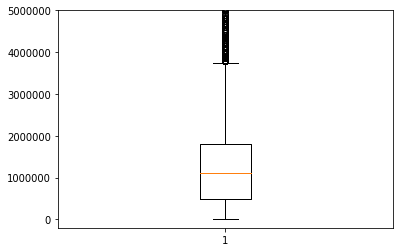

In [93]:
plt.boxplot(df.price)
plt.ylim(-200000,5000000)
plt.show()

In [94]:
#check price stats
median = np.median(df.price)
upper_quartile = np.percentile(df.price, 75)
lower_quartile = np.percentile(df.price, 25)
iqr = upper_quartile - lower_quartile
upper_whisker = df.price[df.price<=upper_quartile+1.5*iqr].max()
lower_whisker = df.price[df.price>=lower_quartile-1.5*iqr].min()
print("median: {} , Q3: {}, Q1: {},upper_whisker: {} ,lower_whisker: {}".format(median,upper_quartile,lower_quartile,upper_whisker,lower_whisker))

median: 1100000.0 , Q3: 1800000.0, Q1: 500000.0,upper_whisker: 3750000.0 ,lower_whisker: 800.0


In [95]:
# check number of outliers in price
df[df.price>3750000].shape

(1037, 10)

In [96]:
# remove price outliers
df=df[df.price<3750000]

In [97]:
# check number of outliers in price
df[df.price<100000].shape

(1087, 10)

In [98]:
# remove price outliers
print(df[df.price.between(100000,3750000)].shape)
df=df[df.price.between(100000,3750000)]

(24336, 10)


#### Enhancing correlation

#### >>Area

(-50, 500)

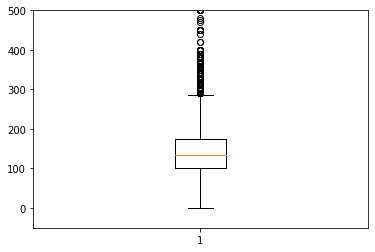

In [99]:
plt.boxplot(df.Area)
plt.ylim(-50,500)

In [100]:
median = np.median(df.Area)
upper_quartile = np.percentile(df.Area, 75)
lower_quartile = np.percentile(df.Area, 25)

iqr = upper_quartile - lower_quartile
upper_whisker = df.Area[df.Area<=upper_quartile+1.5*iqr].max()
lower_whisker = df.Area[df.Area>=lower_quartile-1.5*iqr].min()
print("median: {} , Q3: {}, Q1: {},upper_whisker: {} ,lower_whisker: {}".format(median,upper_quartile,lower_quartile,upper_whisker,lower_whisker))

median: 135.0 , Q3: 175.0, Q1: 100.0,upper_whisker: 287.0 ,lower_whisker: 0.0


In [101]:
df[df.Area>287].shape

(402, 10)

In [102]:
df[df.Area<50].shape

(46, 10)

In [103]:
# remove Area outliers
df=df[df.Area.between(50,287)]
df.shape

(23888, 10)

In [105]:
# check corr
df[['Area','price']].corr()

,Area,price
Area,1.000000,0.672776
price,0.672776,1.000000


after removing outliers from price and area we increased the area correlation from -0.003480 to 0.672541

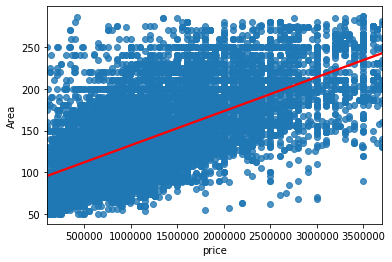

In [106]:
sns.regplot(df.price,df.Area,line_kws = {'color': 'red'})


#### >> Bathroom

{'whiskers': [<matplotlib.lines.Line2D at 0x924a9beb08>,
 'caps': [<matplotlib.lines.Line2D at 0x924a9c2a88>,
 'boxes': [<matplotlib.lines.Line2D at 0x924a9b8fc8>],
 'medians': [<matplotlib.lines.Line2D at 0x924a9c7a08>],
 'fliers': [<matplotlib.lines.Line2D at 0x924a9c7b08>],
 'means': []}

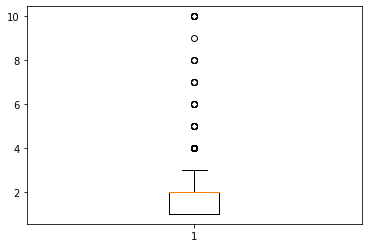

In [40]:
plt.boxplot( df.Bathrooms)

In [41]:
#chek numbers of outliers
df[df.Bathrooms>3].shape

(260, 10)

In [42]:
#chek numbers of outliers
df[df.Bathrooms==0].shape

(0, 10)

In [43]:
# remove Bathrooms outliers
df=df[df.Bathrooms<=3]

In [44]:
#check correlation
df[['Bathrooms','price']].corr()

,Bathrooms,price
Bathrooms,1.000000,0.675259
price,0.675259,1.000000


after removing outliers from bathroom we icreased the correlation from 0.365814 to 0.675171

#### >> Bedrooms

{'whiskers': [<matplotlib.lines.Line2D at 0x924aa27f48>,
 'caps': [<matplotlib.lines.Line2D at 0x924aa2bb08>,
 'boxes': [<matplotlib.lines.Line2D at 0x924aa276c8>],
 'medians': [<matplotlib.lines.Line2D at 0x924aa2fa88>],
 'fliers': [<matplotlib.lines.Line2D at 0x924aa35908>],
 'means': []}

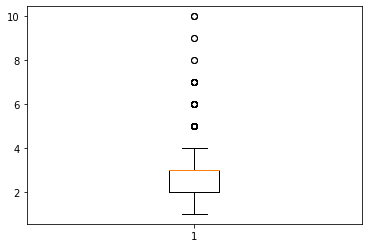

In [45]:
#check data distribution
plt.boxplot(df.Bedrooms)

In [46]:
#check price stats
median = np.median(df.Bedrooms)
upper_quartile = np.percentile(df.Bedrooms, 75)
lower_quartile = np.percentile(df.Bedrooms, 25)
iqr = upper_quartile - lower_quartile
upper_whisker = df.Bedrooms[df.Bedrooms<=upper_quartile+1.5*iqr].max()
lower_whisker = df.Bedrooms[df.Bedrooms>=lower_quartile-1.5*iqr].min()
print("median: {} , Q3: {}, Q1: {},upper_whisker: {} ,lower_whisker: {}".format(median,upper_quartile,lower_quartile,upper_whisker,lower_whisker))

median: 3.0 , Q3: 3.0, Q1: 2.0,upper_whisker: 4 ,lower_whisker: 1


In [47]:
# check shape of outliers
df[df.Bedrooms>4].shape

(127, 10)

In [48]:
# remove outliers of Bedrooms
df=df[df.Bedrooms<=4]

In [49]:
# check correlation
df[['Bedrooms','price']].corr()

,Bedrooms,price
Bedrooms,1.000000,0.360329
price,0.360329,1.000000


after removing outliers from Bedroom we icreased the correlation from 0.276485 to 0.359961

#### >> Level

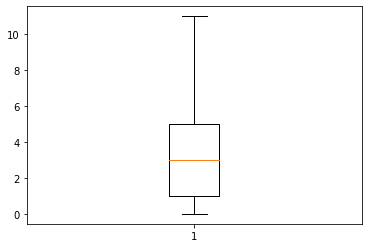

In [50]:
plt.boxplot(df.Level)
plt.show()

In [51]:
df[['Level','price']].corr()

,Level,price
Level,1.000000,-0.160855
price,-0.160855,1.000000


#### >> Furnished

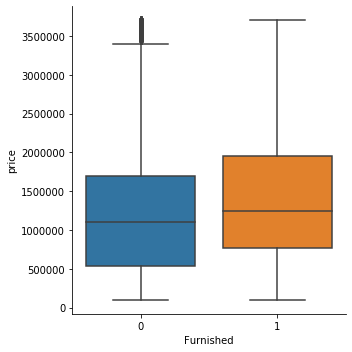

In [128]:
sns.catplot(x="Furnished", y="price", kind="box", data=df)

most of data are overlapped(small variance between data)

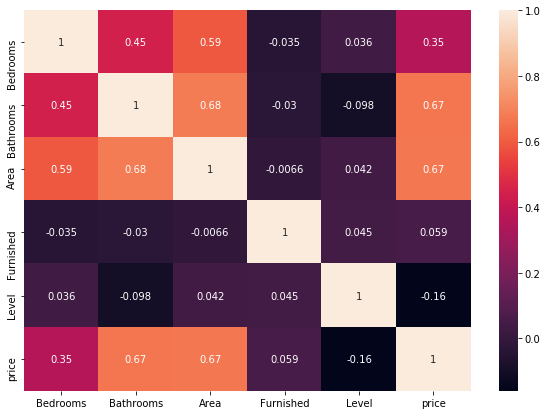

In [132]:
#### check final correlation
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(),annot = True)

### Add More Features

In [133]:
df.head()

,Amenities,Bedrooms,Bathrooms,Area,Furnished,Level,location,Compound,price,title
0,"Balcony,Security,Covered Parking,Electricity M...",3,2,135.0,0,5,Madinaty,Madinaty,1600000.0,مدينتي ١٣٥م بال B1 بحري قريبه جدا من الخدم...
1,"Balcony,Pets Allowed,Private Garden,Security,E...",3,2,140.0,0,2,Badr City,El Ashgar District,355000.0,شقة بسعر التكلفة في الحي المتميز مدينة بدر...
2,No,3,3,180.0,0,0,Rehab City,Not in Compound,3100000.0,فرررصة برحاب ٢ للبيع شقة ١٨٠م ارضي بحديقة ...
3,"Balcony,Pets Allowed,Security,Electricity Mete...",2,1,107.0,0,6,Madinaty,Madinaty,1150000.0,شقة بمدينتي بال B1 نموذج 100 اقل من سعر ال...
4,"Balcony,Electricity Meter",2,1,80.0,0,6,Marg,Not in Compound,185000.0,شقة تشطيب فاخر للبيع


In [55]:
df.shape

(23501, 10)

#### >> Compound

In [144]:

df_comp=df[df.Compound.isin(df.Compound.value_counts().reset_index(name='count').query('count>50')['index'])]
df_comp.Compound.value_counts()

Not in Compound            17358
Madinaty                    2622
Rehab City                   732
The Square                   275
Mountain View Hyde Park      268
Eastown                      244
Dar Misr                     229
VGK                          204
Galleria Moon Valley         140
Tag Sultan                   138
Baron City                    94
2020 Compound                 82
Stone Residence               78
Hyde Park New Cairo           55
Name: Compound, dtype: int64

<Figure size 1440x720 with 0 Axes>

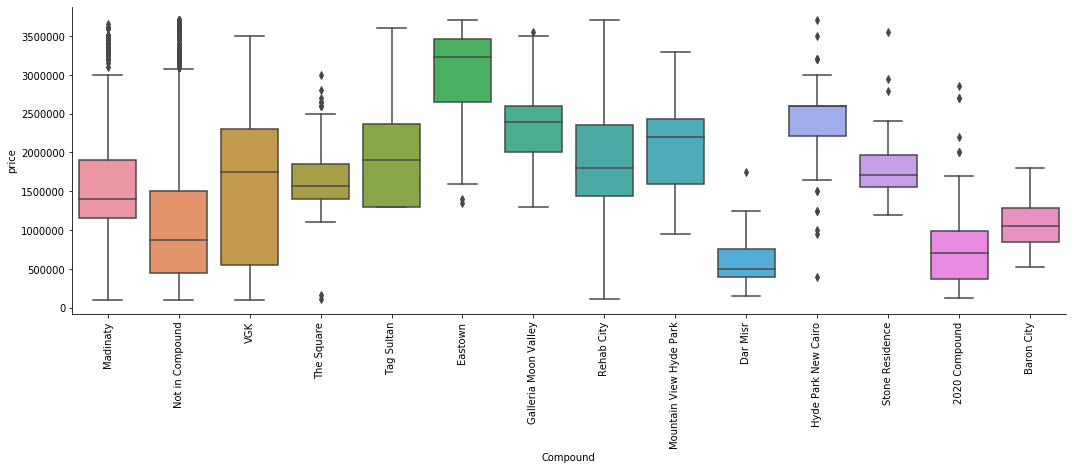

In [145]:
plt.figure(figsize=(20,10))
sns.catplot(x='Compound',y='price',kind="box", data=df_comp,height=5, # make the plot 5 units high
    aspect=3)
plt.xticks(rotation=90)
plt.show()

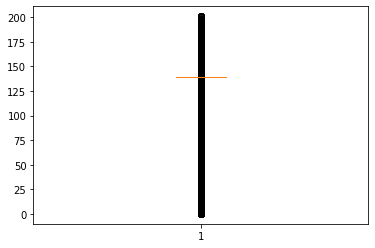

In [143]:
plt.boxplot(df_Comp.Compound)
plt.show()

#### >> City

In [58]:
df_comp.location.value_counts().sort_values()[:20]

Garden City           5
Darrasa               6
Tebeen                7
Ataba                 8
Moski                 8
Ma'sara               8
Gamaleya             10
Darb al-Ahmar        11
Boulaq               13
Tura                 16
Bab al-Shereia       16
El Fostat            26
Rod al-Farag         28
New Capital City     28
Helmeya al-Gadeda    31
Qasr al-Nil          33
Mostakbal City       36
Basateen             36
Al Amiriyyah         40
Masr al-Kadema       41
Name: location, dtype: int64

In [59]:
df_comp_loc=df_comp[df_comp.location.isin(df_comp.location.value_counts().reset_index(name='count').query('count>50')['index'])]
df_comp_loc.location.value_counts().sort_values()[:7]

New Heliopolis               52
Katameya                     60
Abasiya                      61
Zamalek                      66
Waili                        68
Ramses + Ramses Extension    81
Zawya al-Hamra               97
Name: location, dtype: int64

<Figure size 1440x360 with 0 Axes>

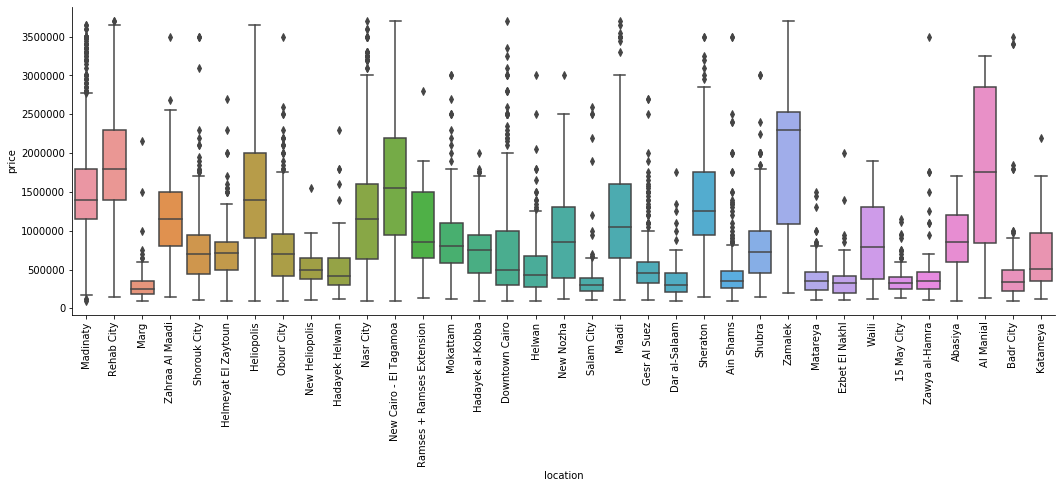

In [60]:
plt.figure(figsize=(20,5))
sns.catplot(x='location',y='price',kind="box", data=df_comp_loc,height=5, # make the plot 5 units high
    aspect=3)
plt.xticks(rotation=90)
plt.show()

In [61]:
print(df_comp_loc.shape)

(21602, 10)


In [187]:
# check significancy of Compound
enc = LabelEncoder()
df_comp['LabeledCompound']=enc.fit_transform(df_comp['Compound'])
df_comp['Labeledlocation']=enc.fit_transform(df_comp['location'])

                 LabeledCompound  Labeledlocation     price
LabeledCompound         1.000000         0.038987 -0.086172
Labeledlocation         0.038987         1.000000  0.200348
price                  -0.086172         0.200348  1.000000


G:\Users\SAAD\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
G:\Users\SAAD\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


''

In [195]:
cols=df_comp.loc[:, df_comp.columns[1:6].append(df_comp.columns[10:12])].columns
cols

Index(['Bedrooms', 'Bathrooms', 'Area', 'Furnished', 'Level',
       'LabeledCompound', 'Labeledlocation'],
      dtype='object')

In [197]:
from sklearn.feature_selection import chi2
res = chi2(df_comp.loc[:, df_comp.columns[1:6].append(df_comp.columns[10:12])], df_comp['price'])
features = pd.DataFrame({
    'features': cols,
    'chi2': res[0],
    'p-value': res[1]
})
features

,features,chi2,p-value
0,Bedrooms,616.261234,4.104752e-01
1,Bathrooms,4017.330728,0.000000e+00
2,Area,196553.521250,0.000000e+00
3,Furnished,1406.158054,6.308443e-65
4,Level,3760.039376,0.000000e+00
5,LabeledCompound,789.797506,9.666122e-07
6,Labeledlocation,10650.121283,0.000000e+00


#### >> Aminities

In [62]:
# convert comma separated aminities into lists
df_comp_loc['Amenities']=df_comp_loc.Amenities.apply(lambda x: x.split(','))
df_comp_loc.head()

G:\Users\SAAD\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Amenities,Bedrooms,Bathrooms,Area,Furnished,Level,location,Compound,price,title
0,"[Balcony, Security, Covered Parking, Electrici...",3,2,135.0,0,5,Madinaty,Madinaty,1600000.0,مدينتي ١٣٥م بال B1 بحري قريبه جدا من الخدم...
2,[No],3,3,180.0,0,0,Rehab City,Not in Compound,3100000.0,فرررصة برحاب ٢ للبيع شقة ١٨٠م ارضي بحديقة ...
3,"[Balcony, Pets Allowed, Security, Electricity ...",2,1,107.0,0,6,Madinaty,Madinaty,1150000.0,شقة بمدينتي بال B1 نموذج 100 اقل من سعر ال...
4,"[Balcony, Electricity Meter]",2,1,80.0,0,6,Marg,Not in Compound,185000.0,شقة تشطيب فاخر للبيع
6,"[Electricity Meter, Water Meter, Natural Gas]",3,1,85.0,0,6,Zahraa Al Maadi,Not in Compound,290000.0,شقة للبيع العمارات مصر العليا واجهة بحرية ...


In [63]:
df_comp_loc.shape

(21602, 10)

In [64]:
mlb = MultiLabelBinarizer()
multiLabelBinarizer_df = df_comp_loc.join(pd.DataFrame(mlb.fit_transform(df_comp_loc['Amenities']),
                          columns=mlb.classes_,
                          index=df_comp_loc.index))
multiLabelBinarizer_df.iloc[:,8:]

NameError: name 'MultiLabelBinarizer' is not defined

In [ ]:
# check top features
corr=multiLabelBinarizer_df.iloc[:,8:].corr()
top_feature = corr.index[abs(corr['price']>=0.2)]
plt.subplots(figsize=(12, 8))
top_corr = multiLabelBinarizer_df[top_feature].corr()
sns.heatmap(top_corr, annot=True)
plt.show()

In [ ]:
multiLabelBinarizer_df[multiLabelBinarizer_df.columns.difference(list(top_feature))].columns

In [ ]:
df_comp_loc_amnt=df_comp_loc.copy().reset_index(drop=True)
df_comp_loc_amnt.head(1)

In [ ]:
# test the not correlated aminities functionality
not_correlated_features=list(multiLabelBinarizer_df[multiLabelBinarizer_df.columns.difference(list(top_feature))].columns)
for index,aminities in enumerate(df_comp_loc_amnt.Amenities[:4]):
    print(index,aminities)
    print(list(set(aminities) - set(not_correlated_features)))
    print("--------------------------------------")
    

In [ ]:
# remove the not correlated aminities
not_correlated_features=list(multiLabelBinarizer_df[multiLabelBinarizer_df.columns.difference(list(top_feature))].columns)
df_comp_loc_amnt.Amenities=df_comp_loc_amnt.Amenities.apply(lambda x: list(set(x) - set(not_correlated_features)))
df_comp_loc_amnt.head()

In [ ]:
#test on CountVectorizer to be used in pipeline
vectorizer=CountVectorizer(analyzer=set)
X2=vectorizer.fit_transform(df_comp_loc_amnt['Amenities'])
print(list(df_comp_loc_amnt.iloc[0:4,0].values))

In [ ]:
vectorized_df=pd.DataFrame(X2.toarray(),columns=vectorizer.get_feature_names())
print(vectorized_df.shape,df_comp_loc_amnt.shape)
vectorized_df.head(4)

In [ ]:
df_comp_loc_amnt.to_csv('olx_data_cleaned_for_model')

# Prediction

In [ ]:
df_numerical=df_comp_loc_amnt.loc[:,df_comp_loc_amnt.columns.difference(['Amenities', 'Compound','location','title','price'])]
df_features=df_comp_loc_amnt.loc[:,df_comp_loc_amnt.columns.difference(['price'])]
df_target=df_comp_loc_amnt.loc[:,'price']
df_numerical.columns,df_features.columns

In [ ]:
numeric_features = list(df_numerical.columns)
categorical_features = ['location', 'Compound']
amanities_feature='Amenities'
numeric_transformer = Pipeline(steps=[
    ('scaler', preprocessing.MinMaxScaler())])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])
countVectorizer_transformer = Pipeline(steps=[
    ('countVectorizer',CountVectorizer(analyzer=set))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('multi_label', countVectorizer_transformer, amanities_feature),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
        ])

In [ ]:
sparsed=preprocessor.fit_transform(X_train)
sparsed.toarray()[0]

In [ ]:
#split data to train/test
X=df_features
Y=df_target
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.1,random_state=40)
print('training set: ',X_train.shape,y_train.shape)
print('test set: ',X_test.shape,y_test.shape)
X_train.head(2)

In [ ]:
def train_model(model):
    global y_hat
    pipeline = Pipeline(steps=[('preprocessor',preprocessor),('model', model)])
    pipeline.fit(X_train,y_train)
    y_hat=pipeline.predict(X_test)
    y_hat_train=pipeline.predict(X_train)
    print('R square:{:0.2f} '.format(r2_score(y_test,y_hat))) 
    print('Train R square:{:0.2f} '.format(r2_score(y_train,y_hat_train))) 
    return pipeline

### 1. Linear Regression

In [ ]:
# train the linear regression model
reg = linear_model.LinearRegression()
reg=train_model(reg)
pickle.dump(reg, open('Reg_model.pkl','wb'))

In [ ]:
# cross validation
scores = cross_val_score(reg, X, Y, cv=50)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
scores

##### Linear Model regularization (Lasso and Ridge Regression) to prevent overfitting

In [ ]:
clf_ridge = linear_model.Ridge(alpha=.09)
clf_Lasso = linear_model.Ridge(alpha=1)
train_model(clf_ridge)
train_model(clf_Lasso);

### 2. KNN

In [ ]:
neigh = KNeighborsRegressor(n_neighbors=14)
neigh=train_model(neigh);
# serialize the model 
pickle.dump(neigh, open('KNN_model.pkl','wb'))

In [ ]:
# cross validation
scores = cross_val_score(neigh, X, Y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
scores

### 3. GBoost

In [ ]:
acc={}
params = {'n_estimators': 1000,#the number of boosting stages
          'max_depth': 6,#limits the number of nodes in the tree
          'min_samples_split': 4,# the minimum number of samples required to split an internal node.
          'learning_rate': 0.01,#how much the contribution of each tree will shrink.
          'loss': 'ls',
          'random_state':0
          #'booster':'gblinear'
         }#loss function to optimize. The least squares function is used in this case

gBoost_model=ensemble.GradientBoostingRegressor(**params)
gBoost_model=train_model(gBoost_model)

In [ ]:
# cross validation
scores = cross_val_score(pipeline, X, Y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

## Prediction

In [ ]:
# serialize the model 
pickle.dump(gBoost_model, open('GBoost_model.pkl','wb'))

In [ ]:
#Test Data
dict_test={'Amenities':['Balcony', 'Landline'],'Area':180,'Bathrooms':3,'Bedrooms':3,"Compound":"Rehab City",'Furnished':0,'Level':3,'location':"Rehab City"}
columns = list(dict_test.keys())
values = list(dict_test.values())
arr_len = len(values)
test_row=pd.DataFrame(np.array(values, dtype=object).reshape(1, arr_len), columns=columns)
test_row

In [ ]:
model = pickle.load(open('GBoost_model.pkl','rb'))
print('GBoost : {:,.2f}'.format(model.predict(test_row)[0]))

In [ ]:
ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_hat, hist=False, color="b", label="Fitted Values" , ax=ax1)

#### train the model on all data

In [ ]:
acc={}
params = {'n_estimators': 1000,#the number of boosting stages
          'max_depth': 6,#limits the number of nodes in the tree
          'min_samples_split': 4,# the minimum number of samples required to split an internal node.
          'learning_rate': 0.01,#how much the contribution of each tree will shrink.
          'loss': 'ls',
          #'booster':'gblinear'
         }#loss function to optimize. The least squares function is used in this case

gBoost_model=ensemble.GradientBoostingRegressor(**params)
pipeline = Pipeline(steps=[('preprocessor',preprocessor),('model', gBoost_model)])
pipeline.fit(X,Y)
y_hat=pipeline.predict(X_test)
print('R square:{:0.2f} '.format(r2_score(y_test,y_hat))) 